In [1]:
# To run this example, move this file to the main directory of this repository
import os
import sys
sys.path.insert(0,'..')
from citylearn import  CityLearn
from pathlib import Path
import numpy as np                                   
import torch
import matplotlib.pyplot as plt
from agents.sac import SAC as Agent

In [2]:
# Load environment
climate_zone = 5
data_path = Path("../data/Climate_Zone_"+str(climate_zone))
sim_period = (0, 8760*4-1)
building_ids = ["Building_"+str(i) for i in [1,2,3,4,5,6,7,8,9]]
params = {'data_path':data_path, 
        'building_attributes':'building_attributes.json', 
        'weather_file':'weather_data.csv', 
        'solar_profile':'solar_generation_1kW.csv', 
        'carbon_intensity':'carbon_intensity.csv',
        'building_ids':building_ids,
        'buildings_states_actions':'buildings_state_action_space.json', 
        'simulation_period': sim_period, 
        'cost_function': ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','carbon_emissions'], 
        'central_agent': False,
        'save_memory': False }

# Contain the lower and upper bounds of the states and actions, to be provided to the agent to normalize the variables between 0 and 1.
env = CityLearn(**params)
observations_spaces, actions_spaces = env.get_state_action_spaces()

# Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
building_info = env.get_building_information()

In [3]:
params_agent = {'building_ids':building_ids,
                 'buildings_states_actions':os.path.join(data_path,'buildings_state_action_space.json'), 
                 'building_info':building_info,
                 'observation_spaces':observations_spaces, 
                 'action_spaces':actions_spaces}

# Instantiating the control agent(s)
agents = Agent(**params_agent)

state = env.reset()
done = False

action, coordination_vars = agents.select_action(state)    
while not done:
    next_state, reward, done, _ = env.step(action)
    action_next, coordination_vars_next = agents.select_action(next_state)
    agents.add_to_buffer(state, action, reward, next_state, done, coordination_vars, coordination_vars_next)
    coordination_vars = coordination_vars_next
    state = next_state
    action = action_next

env.cost()

Device:cuda


..\agents\sac.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(actions), None


({'ramping': 1.5697258,
  '1-load_factor': 1.0934938117218105,
  'average_daily_peak': 1.1146264,
  'peak_demand': 1.0899074,
  'net_electricity_consumption': 1.0091007,
  'carbon_emissions': 1.0153203,
  'total': 1.148695725936891,
  'coordination_score': 1.2169383447456381},
 {'ramping_last_yr': 1.1921027,
  '1-load_factor_last_yr': 1.0590656208209517,
  'average_daily_peak_last_yr': 1.0617559,
  'peak_demand_last_yr': 1.068979,
  'net_electricity_consumption_last_yr': 1.0035809,
  'carbon_emissions_last_yr': 1.0101062,
  'coordination_score_last_yr': 1.095475802998054,
  'total_last_yr': 1.0701523069684762})

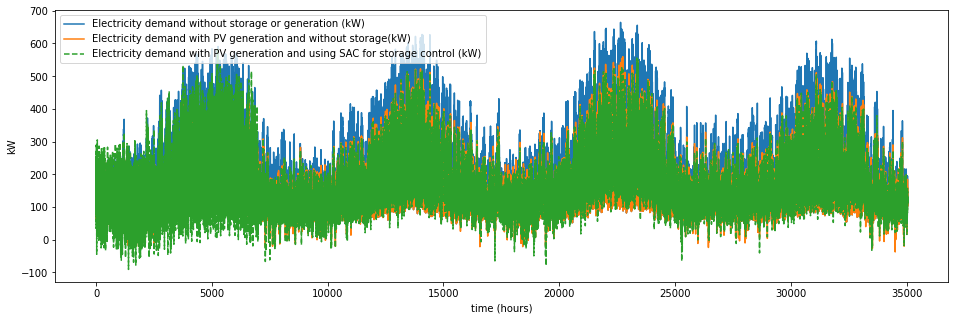

In [4]:
sim_period = (0, 8760*4 - 1)
interval = range(sim_period[0], sim_period[1])
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 
            'Electricity demand with PV generation and without storage(kW)', 
            'Electricity demand with PV generation and using SAC for storage control (kW)'])

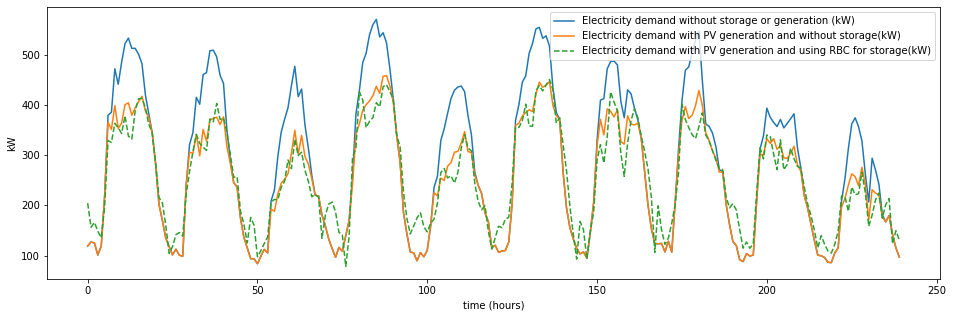

In [5]:
# Plotting summer operation in the last year
interval = range(8760*3 + 24*30*6, 8760*3 + 24*30*6 + 24*10)
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 
            'Electricity demand with PV generation and without storage(kW)', 
            'Electricity demand with PV generation and using RBC for storage(kW)'])

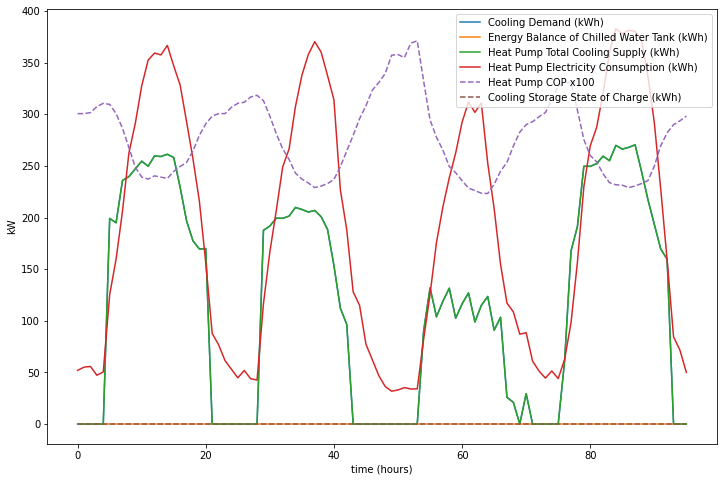

In [6]:
building_number = 'Building_1'
interval = (range(24*30*6 + 8760*3,24*30*6 + 8760*3 + 24*4))
plt.figure(figsize=(12,8))
plt.plot(env.buildings[building_number].cooling_demand_building[interval])
plt.plot(env.buildings[building_number].cooling_storage_to_building[interval] - env.buildings[building_number].hvac_device_to_cooling_storage[interval])
plt.plot(env.buildings[building_number].hvac_device.cooling_supply[interval])
plt.plot(env.electric_consumption_cooling[interval])
plt.plot(env.buildings[building_number].hvac_device.cop_cooling[interval]*100,'--')
plt.plot(env.buildings[building_number].cooling_storage.soc[interval],'--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Cooling Demand (kWh)',
            'Energy Balance of Chilled Water Tank (kWh)', 
            'Heat Pump Total Cooling Supply (kWh)', 
            'Heat Pump Electricity Consumption (kWh)',
            'Heat Pump COP x100',
            'Cooling Storage State of Charge (kWh)'])

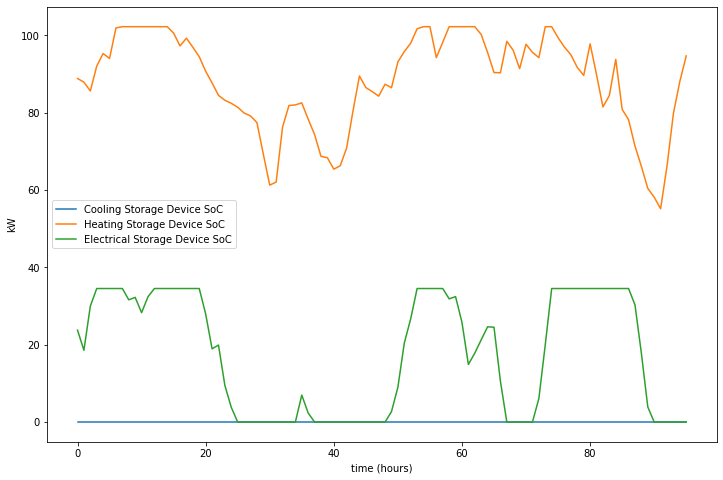

In [7]:
building_number = 'Building_9'
interval = range(8760*3 + 24*30*6, 8760*3 + 24*30*6 + 24*4)
plt.figure(figsize=(12,8))
plt.plot(env.buildings[building_number].cooling_storage_soc[interval])
plt.plot(env.buildings[building_number].dhw_storage_soc[interval])
plt.plot(env.buildings[building_number].electrical_storage_soc[interval])
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Cooling Storage Device SoC',
            'Heating Storage Device SoC', 
            'Electrical Storage Device SoC'])